# 1. Introdução

Neste notebook iremos implementar e avaliar o primeiro modelo não linear de classificação, utilizando o dataset fornecido. O segundo modelo se encontra no arquivo ```modelo_nao_linear2.ipynb```. 

# 2. Necessidade dos modelos não lineares

No notebook ```modelo_linear.ipynb``` vimos que modelos lineares assumem uma forte suposição nos dados, ou seja, o decision threshold (limiar de decisão) assume uma forma linear. 

Em modelos como a regressão logística, essa suposição pode ser adequada em cenários onde o objetivo principal é a generalização e a estrutura dos dados não exige grande flexibilidade. 

Entretanto essa situação muda quando trabalhamos com muitos dados e esses estando intricados, já que o modelo linear não vai conseguir capturar a complexidade da fronteira de decisão. 

Nesse contexto surge os modelos não lineares onde a fronteira de decisão segue um formato não linear, o que ajuda quando nossos dados estão distribuídos de forma complexa e uma fronteira "curvada" iria capturar melhor a forma como eles se distribuem.

Este notebook implementará o modelo não linear KNN (K-Nearest Neighbors).

# 3. O classificador KNN

## 3.1 O que é o classificador KNN?

Vamos primeiro explicar o que é o KNN para entender sua escolha. A lógica do KNN é relativamente simples, ele vai pegar pontos parecidos e colocá-los na mesma classe. 

Ele não constrói um modelo na etapa de treinamento como o SVM, QDA e LDA, ao invés disso, ele vai calcular a distância de um novo ponto para todos os outros pontos do treino e vai selecionar os K mais próximos desse novo ponto e fazer uma votação utilizando as classes desses K-mais-próximos ponto. 
A classe que mais se repetir dentre esses K pontos será atribuída a esse novo ponto. 

Resumidamente, o KNN cria fronteiras altamente não lineares, adaptadas localmente aos dados. Ele desenha regiões complexas que o LDA não consegue, que o QDA exagera e que o SVM aproxima de forma mais suave.

## 3.2 K pequeno

Um K pequeno gera uma fronteira irregular já que os novos pontos vão estar condicionados apenas a alguns pontos e isso pode acabar gerando overfitting ao capturar muitos ruídos dos poucos pontos.

## 3.3 K grande

Um K grande gera uma fronteira mais suave já que os novos pontos vão estar condicionados a muitos pontos, mas isso pode acabar ignorando padrões e gerar underfitting. 

## 3.4 Métrica da distância dos pontos críticos

Por padrão, usa-se a distância euclidiana como métrica de similaridade entre os pontos de dados. Ela é a linha reta da menor distância entre dois pontos em um plano ou espaço n-dimensional. Mas ela só funciona bem se as variáveis estão na mesma escala. Com isso, faz se necessário a normalização do KNN, se não, as escalas grandes vão dominar e o modelo perde o sentido. Diferente de algoritmos de raio fixo, no KNN nós escolhemos o K previamente. Isso garante que o algoritmo sempre encontre vizinhos para votar, pois a busca por eles se expande até encontrar exatamente o número K de pontos mais próximos, independentemente da distância que eles estejam.

## 3.5 Quando ele é bom?

Ele funciona bem com um baixo número de variáveis pois em alta dimensionalidade, tudo fica longe e o conceito de estar perto e de estar longe é parecido. Ele funciona bem também em situações de muitos pontos, pois isso ajuda o KNN a decidir melhor, mas temos que ter em mente que isso também pode ser prejudicial computacionalmente, uma vez que muitos pontos levam mais tempo para terem suas distâncias até um novo ponto calculadas. Em um dataset de 8708 observações isso é pesado, mas aceitável, por isso utilizamos ele, um problema seria se fossemos utlizar um dataset com um milhão de observações por exemplo, isso deixaria o modelo muito lento. Por fim, ele funciona muito bem quando as classes estão bem separadas localmente.

## 3.6 Quando ele é mal?

Ele funciona mal em dimensões muito altas, chamamos isso de Curse of dimensionality. Ou seja, quando o D (dimensão) cresce, todas as distâncias acabam ficando parecidas e o conceito de vizinho mais próximo perde o sentido, fazendo com que o KNN erre mais, mesmo com muitos dados.

## 3.7 Por que utilizar o classificador KNN?

Temos um número razoável de observações (N = 8708), mas uma dimensionalidade muito alta (D=252). Isso faz com que o KNN nesse dataset funcione razoavelmente, ele é simples e não assume nada, mas não é uma situação ótima, devido a essa alta dimensionalidade. Ele apresenta um desempenho inferior ao nosso próximo método não linear, o SVM. Pensamos em usá-lo em nosso Homework para entender as diferenças entre os modelos pois esse é o nosso foco e não apenas escolher apenas aquele que é melhor modelo.


# 4. Como implementar

## 4.1 Bibliotecas

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV #busca automática dos melhores hiperparâmetros
from sklearn.preprocessing import StandardScaler #pra normalizar os dados
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay #as nossas métricas de avaliação


from sklearn.neighbors import KNeighborsClassifier #como vamos implementar o KNN

## 4.2 Carregamento dos dados

In [43]:
train = pd.read_csv("../data/training.csv")
test = pd.read_csv("../data/testing.csv")

X_train = train.drop(columns=["Class"]) #tira classe como atributo
y_train = train["Class"]

X_test = test.drop(columns=["Class"])
y_test = test["Class"]

#os X's são as matrizes das 252 variáveis
#os Y's são o vetor da classe binária (0 = sem sucesso, 1 = sucesso)

## 4.3 Pré-processamento

In [44]:
scaler = StandardScaler() #KNN é obrigatório a normalização, o standarscaler vai deixar todas as variáveis com  média zero e desvio padrão 1, contribuindo igualmente para a distância
X_train_scaled = scaler.fit_transform(X_train) #aprende parâmetros a partir dos dados
X_test_scaled = scaler.transform(X_test) #usa os mesmos parâmetros aprendidos acima, os valores da méedia e do desvio padrão não existem antes do fit

## 4.4 Ajuste de hiperparâmetros

A perfomance dos modelos não lineares depende muito da escolha dos hiperparâmetros, por isso usamos a cross-validation para saber qual vai ser a melhor configuração.

In [45]:
param_grid = {
    "n_neighbors": [3, 5, 7, 11], #aqui serão testados o número de vizinhos, usados a votação simples ou usar pesos de distância, valores ímpares evitam o empate
    "weights": ["uniform", "distance"] # uniform -> todos os vizinhos têm o mesmo peso, distance-> vizinhos mais próximos têm peso maior
}#aqui teríamos 8 tipos de modelos diferentes (4x2), vamos escolher 1

#internamente na biblioteca do KNN, é algo como:
#if weights == "uniform":
#    usar votação simples
#elif weights == "distance":
#    usar pesos inversamente proporcionais à distância


knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy") #procuramos a melhor combinação usando a métrica do accuracy para decidir isso e tendo o cross validation = 5
grid.fit(X_train_scaled, y_train)#o fit faz isso para cada combinação dos parâmetros, treinando em 4 e validando na quinta, ao fim, ele vai saber a combinação com melhor accuracy média

best_model = grid.best_estimator_ #aqui teremos o KNN com os melhores parâmetros, esse modelo será avaliado no teste, o _ final indica que é um atributo aprendido e não um método

In [46]:
#para ver quais parâmetros foram escolhidos:
grid.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

foram escolhidos o K sendo 5 e o peso sendo a distância.

## 4.5 Resultados

In [47]:
y_pred = best_model.predict(X_test_scaled) #o modelo que foi treinado com o treino agora recebe dados novos nunca antes visto do teste

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

acc, cm


(0.638996138996139,
 array([[ 95,  94],
        [ 93, 236]]))

Temos então que o nosso modelo acerta cerca de 64% dos casos, confirmamos isso facilmente fazendo um cálculo de divisão com o array da confusion matrix onde:

95 + 236 = número de acertos 

93 + 94 = número de erros

95 + 236 + 93 + 94 = total de exemplos

accuracy = número de acertos/número total de exemplos

accuracy = (95+236)/(95 + 236 + 93 + 94) = 0.638996139 = aproximadamente 64%


## 4.6 Matriz de confusão

Agora vendo a matriz de confusão em um gráfico obtemos:

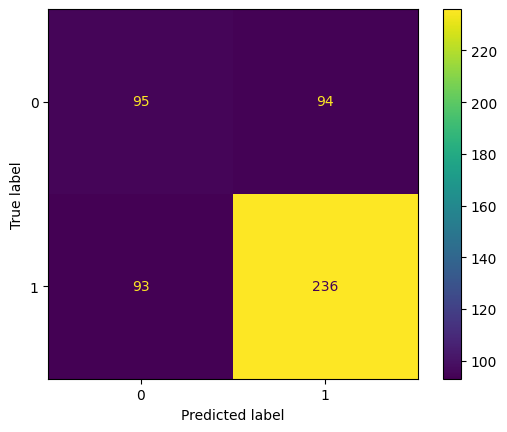

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Verdadeiro Negativo (0 → 0)	95

Falso Positivo (0 → 1)	94

Falso Negativo (1 → 0)	93

Verdadeiro Positivo (1 → 1)	236

Devido à alta dimensionalidade do conjunto de dados, não é possível visualizar diretamente a distribuição das classes no espaço original de atributos. Para fins ilustrativos, pode-se empregar a Análise de Componentes Principais (PCA) como técnica de redução de dimensionalidade, projetando os dados em duas ou três dimensões. Essa projeção permite uma análise qualitativa da separabilidade das classes e da complexidade da fronteira de decisão implícita aprendida pelo modelo KNN, embora não represente fielmente o espaço original de classificação:


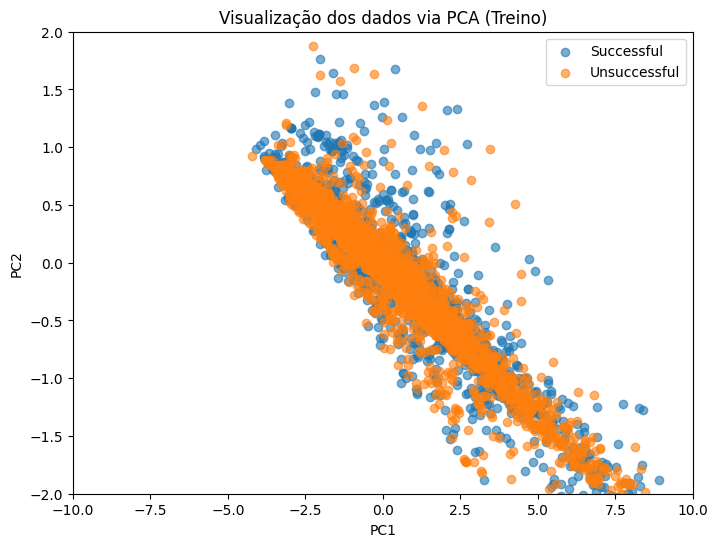

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# separação das classes para plot
mask_success = y_train == "successful"
mask_unsuccess = y_train == "unsuccessful"

plt.figure(figsize=(8,6))

plt.scatter(
    X_train_pca[mask_success, 0],
    X_train_pca[mask_success, 1],
    label="Successful",
    alpha=0.6
)

plt.scatter(
    X_train_pca[mask_unsuccess, 0],
    X_train_pca[mask_unsuccess, 1],
    label="Unsuccessful",
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualização dos dados via PCA (Treino)")
plt.legend()

plt.xlim(-10, 10)
plt.ylim(-2, 2)

plt.show()



# 5. Discussão dos resultados e conclusão

Observa-se que o classificador KNN apresenta um desempenho moderado, com uma accuracy de aproximadamente 64%. A matriz de confusão indica que o modelo possui maior capacidade de identificar corretamente aplicações bem-sucedidas (classe 1) do que aplicações sem sucesso (classe 0). Apesar disso, há um número considerável de falsos positivos e falsos negativos, o que pode sugerir que a alta dimensionalidade, que falamos no começo, dificulta a definição de vizinhanças representativas, o caso do curse of dimensionality, mesmo quando o número de observações é razoável.